In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random
import seaborn
import geopandas as gp
# NOTE: I am ignoring the deprecation warnings on lmafit because I haven't found a way around them yet
warnings.filterwarnings("ignore")

cwd = os.getcwd()
par = os.path.join(cwd, os.pardir)
sys.path.append(par)

# I made some modules to make importing easier and to have a nice class
# that does all the matrix operations
import matrix_operation
import Dataset
import state_set

In [2]:
# Just to reload the modules I imported above so I dont need to restart the kernel after making changes
import importlib
importlib.reload(matrix_operation)
importlib.reload(Dataset)
importlib.reload(state_set)

from matrix_operation import mat_opr
from Dataset import dataset
from state_set import state_data

### Import data

In [3]:
state_dset = state_data()

In [4]:
state_dset = mat_opr(state_dset.dataframe.drop(["Virgin Islands", "Guam"], axis = 1))

### Iso + Normalize

In [5]:
# ia0 and normalize:
state_iso = state_dset.known_iso()
state_norm = state_iso.normalizer()

### Choose a Rank:

In [6]:
state_errors = []
for i in range(15):
    nmfed = state_norm.sci_nmf(components=i+1)
    state_errors.append(state_norm.mean_square_error(nmfed, 0))

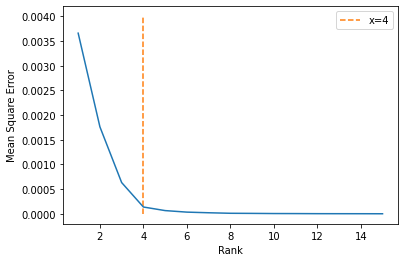

In [7]:
plt.plot(list(range(1,16)), state_errors)
plt.vlines(x=4, ymin=0, ymax= 0.0040, color="tab:orange", linestyle='dashed', label="x=4")
plt.xlabel("Rank")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()

In [8]:
state_ranker = 4

In [9]:
W,H = state_norm.sci_nmf(state_ranker, separate=True)
dotted = pd.DataFrame(np.dot(W,H))
dotted.index = state_norm.dataframe.index
dotted.columns = state_norm.dataframe.columns
state_nmf = mat_opr(dotted)

<AxesSubplot:title={'center':'Massachusetts Cases'}>

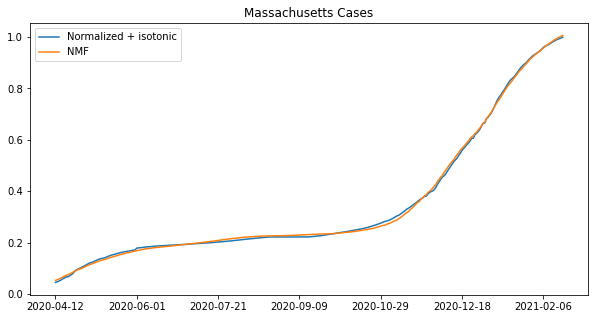

In [10]:
mass = pd.concat([state_norm.dataframe['Massachusetts'], state_nmf.dataframe['Massachusetts']], axis = 1)
mass.columns = ['Normalized + isotonic','NMF']

mass.plot(kind = 'line',legend=True, title = 'Massachusetts Cases', figsize=(10,5))

### Basis Vectors

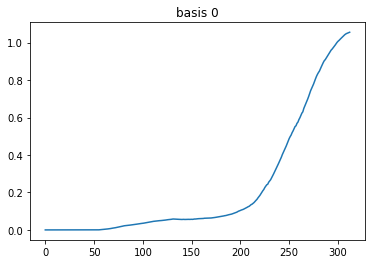

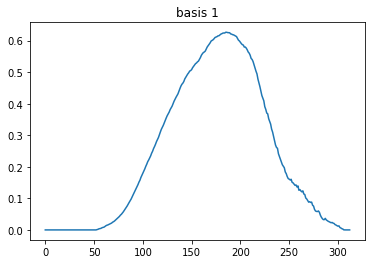

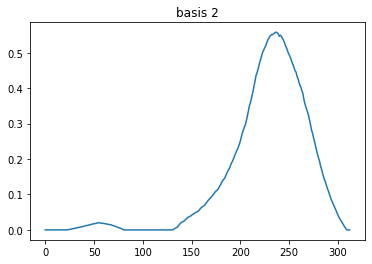

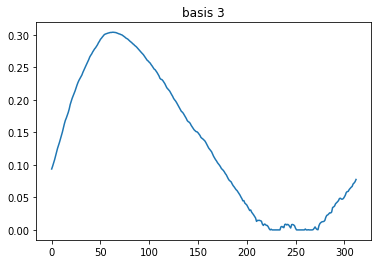

In [11]:
baser = pd.DataFrame(W)
    
for b in baser.columns:
    baser[b].plot()
    plt.title("basis " + str(b))
    plt.show()

## Clustering:

In [12]:
def sort_by_cluster(labels):
    #helper function to see which columns are in which cluster
    cluster_dict = {lab:[] for lab in labels.value_counts().index}
    for i in range(len(labels)):
        cluster_dict[labels[i]].append(i) 
    return cluster_dict

In [13]:
def plot_cluster(data_obj, labels, mean = False, sample_size = 10,legend=False):
    # plots a sample of data (or the mean of that sample) based on clustering results
    subs = labels.value_counts()
    fig, axs = plt.subplots(len(subs), figsize=(14,12))
    clust_dict = sort_by_cluster(labels)
    
    for i in clust_dict.keys():
        if sample_size > len(clust_dict[i]):
            for j in clust_dict[i]:
                data_obj.dataframe.iloc[:,j].plot(ax=axs[i], legend = legend)
        else:
            samples = random.sample(clust_dict[i], sample_size)
            for j in samples:
                data_obj.dataframe.iloc[:,j].plot(ax=axs[i], legend=legend)
        axs[i].set_title("cluster " + str(i))
            
    if mean:
        for k in clust_dict.keys():
            meaner = data_obj.dataframe.iloc[:,clust_dict[k]].mean(axis=1)
            meaner.plot(ax=axs[k], color='k', linewidth=4.0, label='center', legend=legend)

In [14]:
#kmeans = KMeans(n_clusters=3, random_state=9).fit(np.transpose(np.array(state_norm.array)))
#counto = pd.Series(kmeans.labels_)
#plot_cluster(state_norm, counto,mean=True)

### Determine best # of clusters

In [15]:
indexer = []
for i in range(state_ranker):
    indexer.append("basis " + str(i))

In [16]:
h_table = mat_opr(pd.DataFrame(H, index = indexer))
h_clust = np.transpose(np.array(h_table.array))

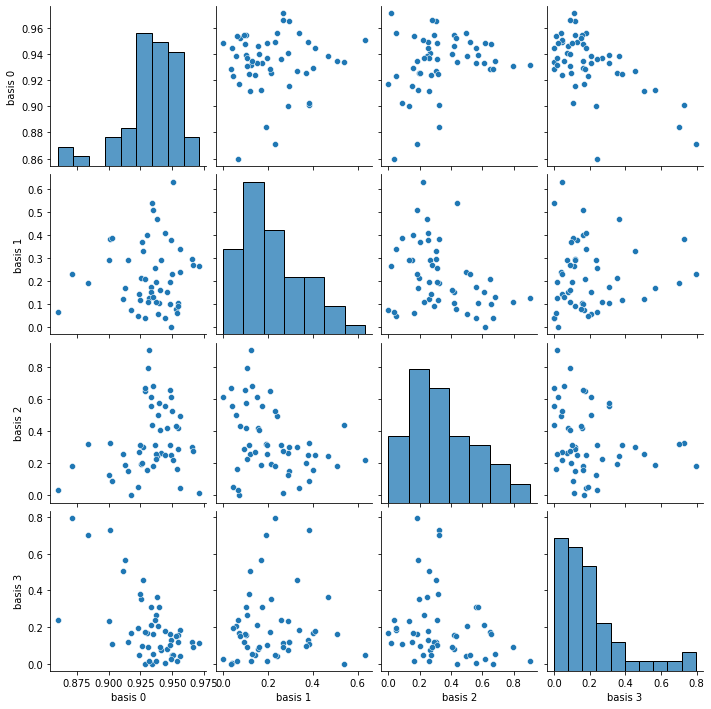

In [17]:
seaborn.pairplot(h_table.dataframe.T)

For n_clusters = 2 The average silhouette_score is : 0.35744216408305873
For n_clusters = 3 The average silhouette_score is : 0.408237456818078
For n_clusters = 4 The average silhouette_score is : 0.3292160169056673
For n_clusters = 5 The average silhouette_score is : 0.31886946117455156


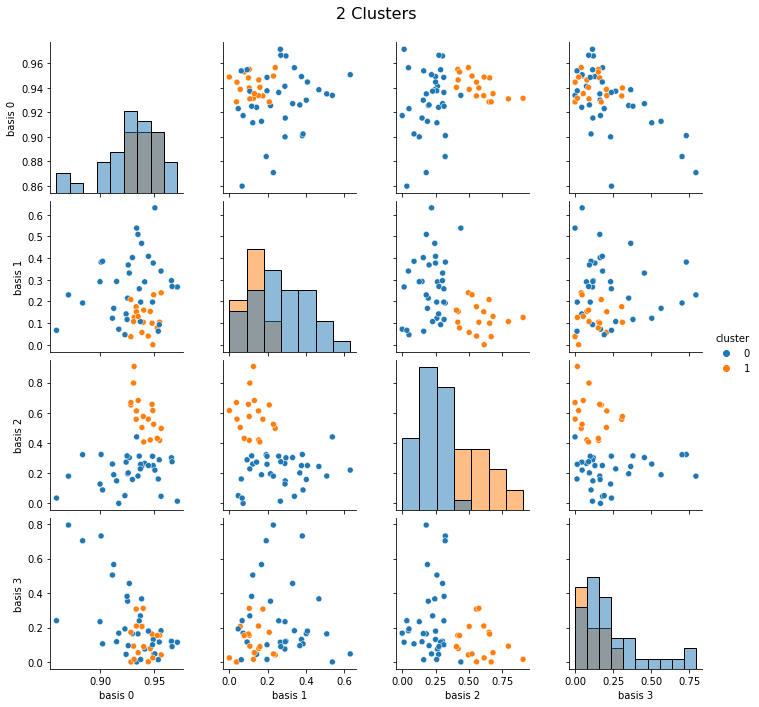

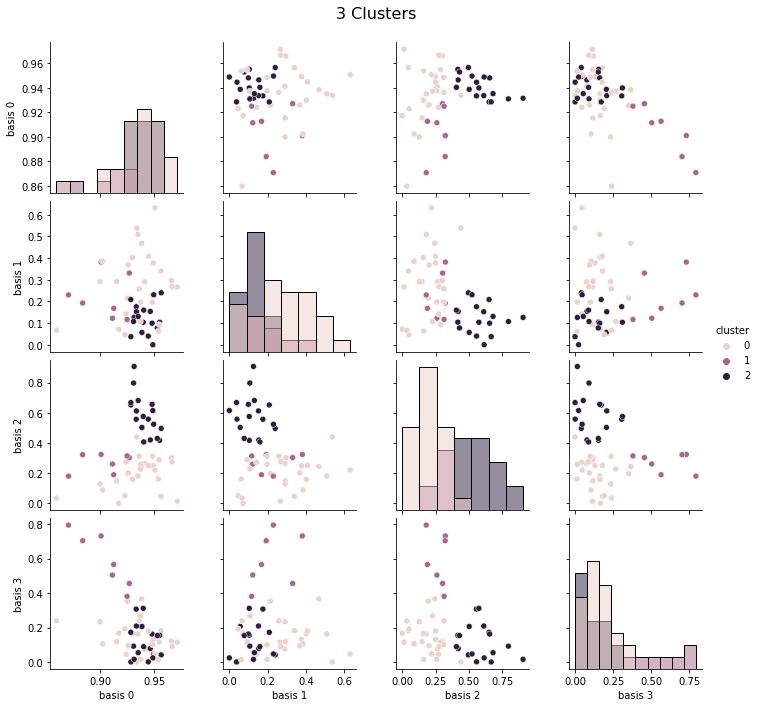

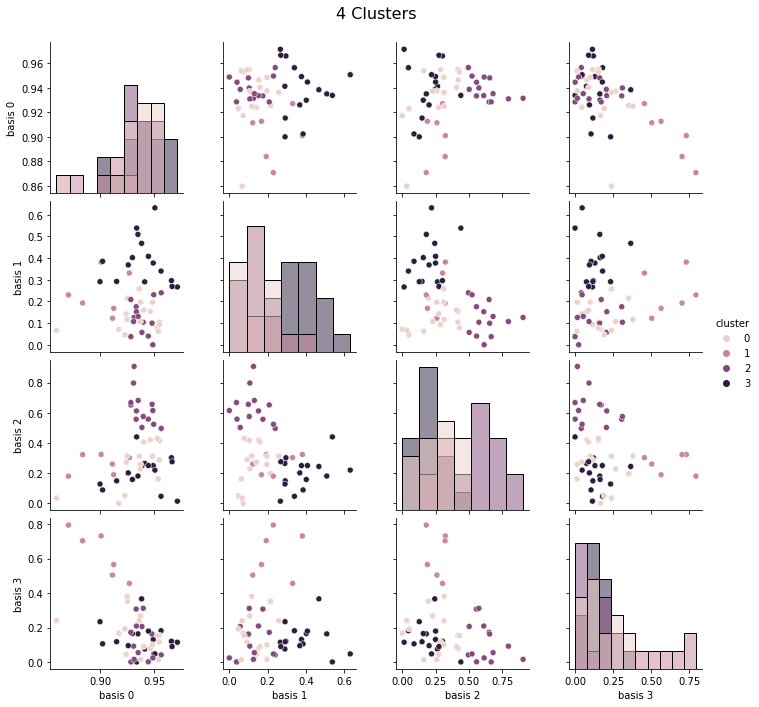

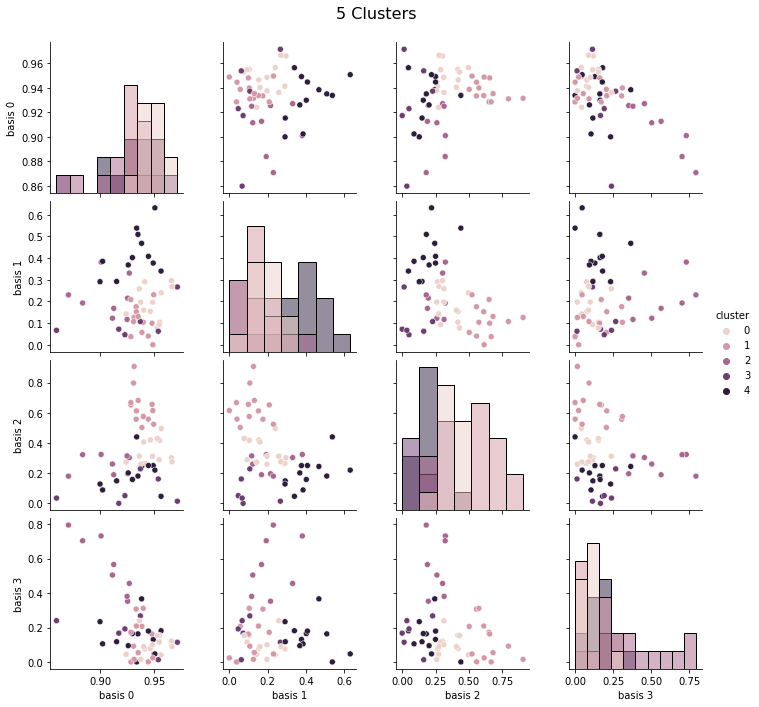

In [18]:
ns = [2,3,4,5]

for n in ns:
    kmeans = KMeans(n_clusters=n, random_state=9).fit(h_clust)
    n_counter = pd.Series(kmeans.labels_)
    
    silhouette_avg = silhouette_score(h_clust, n_counter)
    print("For n_clusters =", n,
          "The average silhouette_score is :", silhouette_avg)
    
    n_cluster_df = h_table.dataframe.T
    n_cluster_df['cluster'] = n_counter

    pp = seaborn.pairplot(n_cluster_df, hue="cluster", diag_kind="hist")
    fig = pp.fig
    fig.subplots_adjust(top=0.93, wspace=0.3)
    t = fig.suptitle(str(n) + " Clusters", fontsize=16)

### Cluster the vectors of Y after decomposition

In [19]:
n_clusters = 3

In [20]:
kmeans = KMeans(n_clusters=n_clusters, random_state=9).fit(h_clust)
counti = pd.Series(kmeans.labels_)

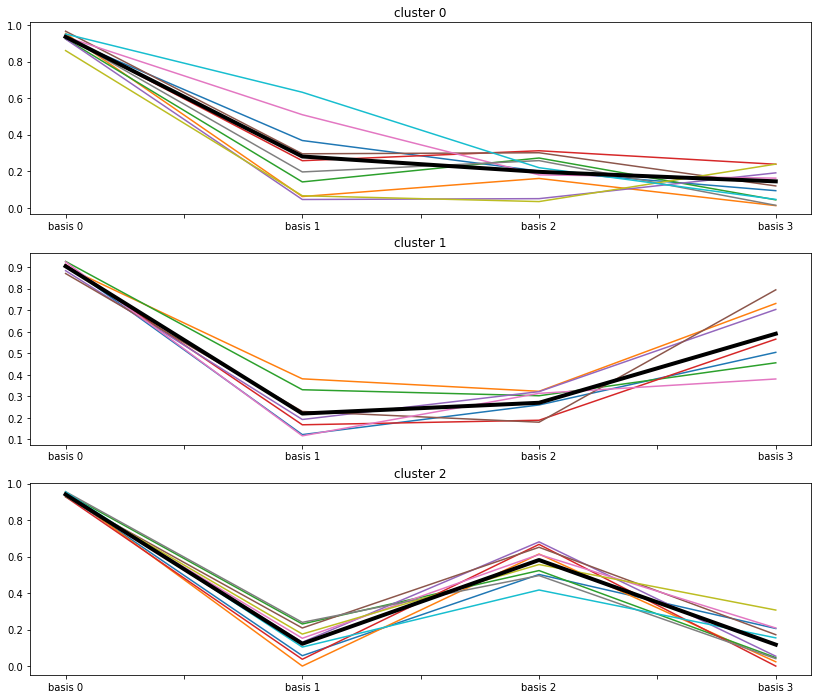

In [21]:
plot_cluster(h_table, counti, mean=True)

### Plot the case curves based on clusters of Y

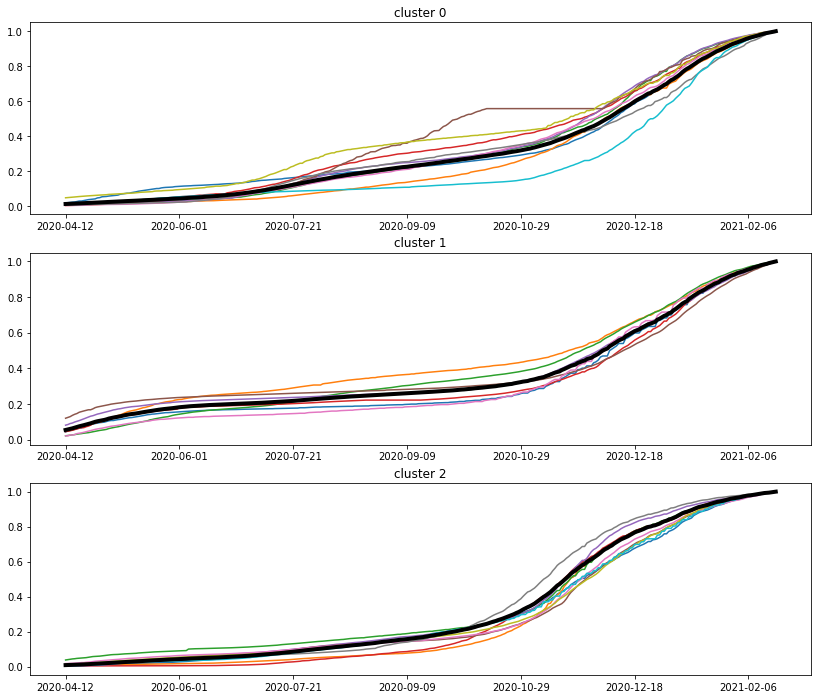

In [22]:
plot_cluster(state_norm, counti, mean=True)

### plot daily increase in cases

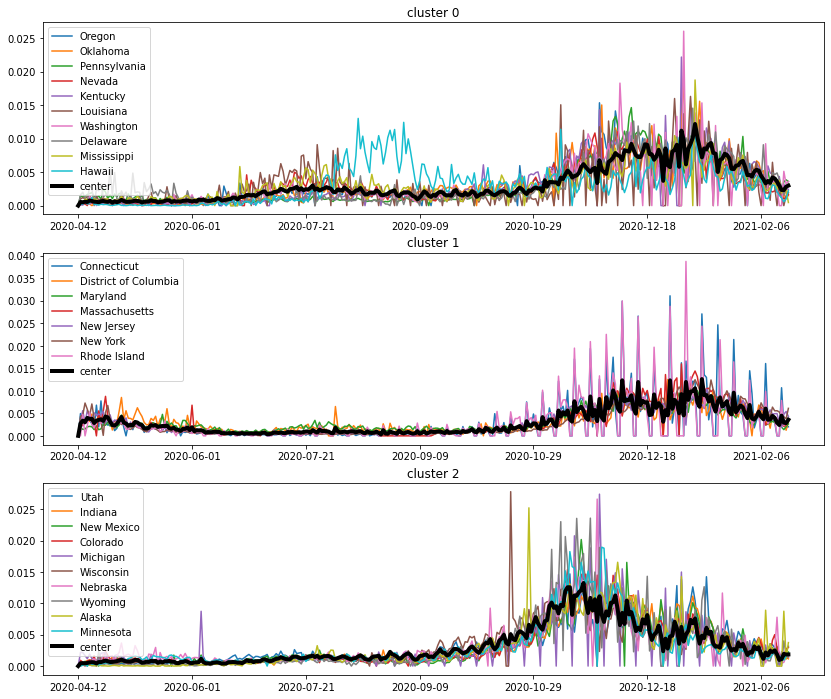

In [23]:
plot_cluster(state_norm.new_case_calc(), counti, mean=True, legend=True)

### Geographical correlation? 

In [24]:
cluster_by_state = {}
for c in counti.index:
    s_name = state_norm.dataframe.iloc[:,c].name
    cluster_by_state[s_name] = counti[c]

In [25]:
state_map = gp.read_file("US_States_geojson.json")

In [26]:
cluster_col = []
for i in state_map["NAME"]:
    cluster_col.append(cluster_by_state[i])

In [27]:
state_map['cluster'] = cluster_col

<AxesSubplot:>

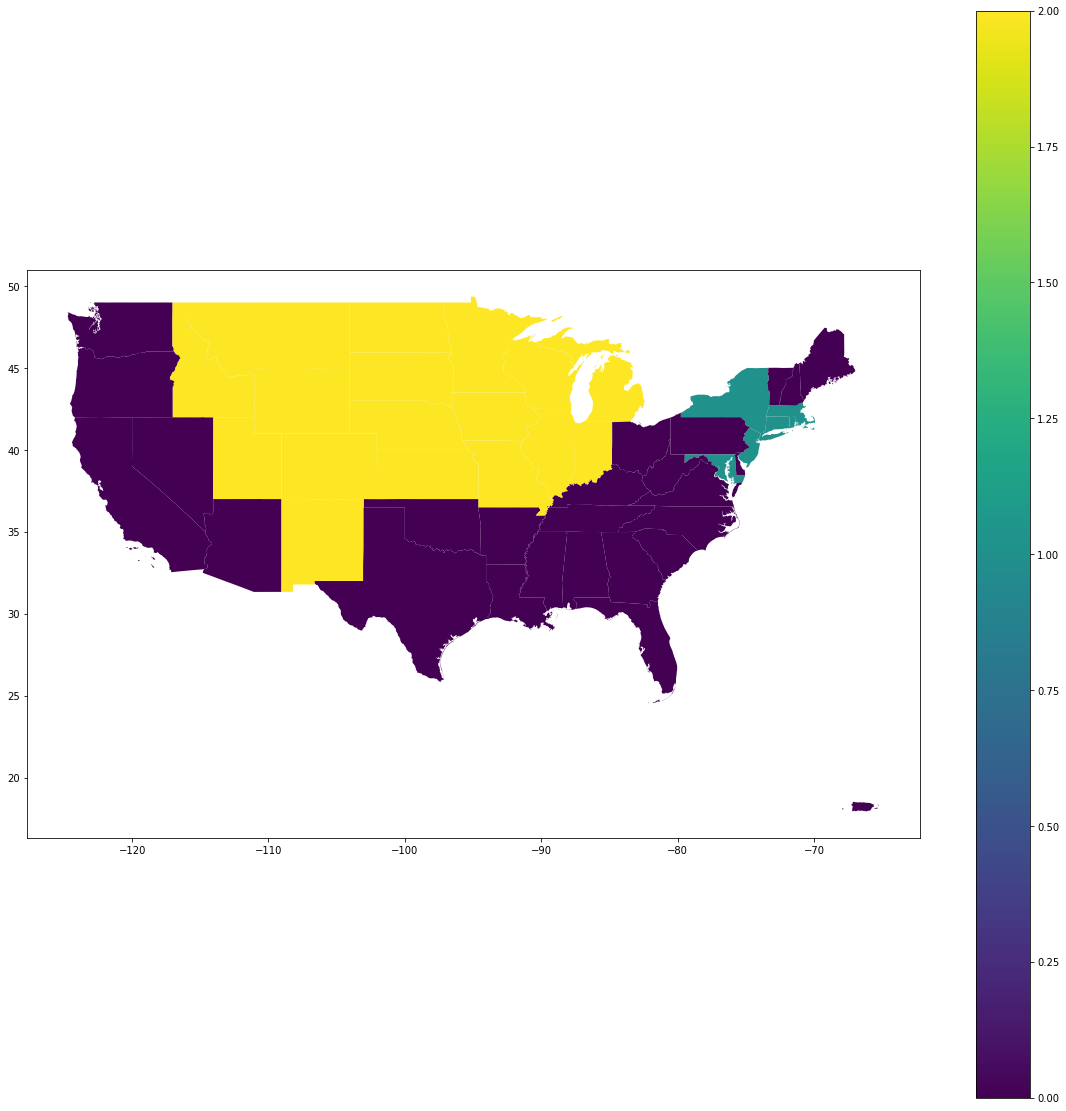

In [28]:
fig,ax = plt.subplots(1,1, figsize=(20,20))
#state_map.plot(column='cluster', ax=ax, legend=True, figsize=(50,50))
state_map[state_map['NAME'].isin(['Alaska','Hawaii']) == False].plot(column='cluster', ax=ax, legend=True, figsize=(50,50))